# Simulation of the effect of pointing errors on MID observations

In [1]:
%matplotlib inline
import sys
import csv, seqfile
import socket, time


from data_models.parameters import arl_path

results_dir = arl_path('test_results')

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame
from data_models.memory_data_models import Skycomponent, SkyModel
from data_models.data_model_helpers import export_pointingtable_to_hdf5

from wrappers.serial.visibility.base import create_blockvisibility
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import simulate_pointingtable
from wrappers.serial.simulation.configurations import create_named_configuration
from wrappers.serial.imaging.primary_beams import create_vp, create_pb
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from processing_components.calibration.pointing import create_pointingtable_from_blockvisibility
from processing_components.simulation.pointing import create_gaintable_from_pointingtable
from wrappers.arlexecute.visibility.base import copy_visibility

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility

from workflows.arlexecute.skymodel.skymodel_arlexecute import predict_skymodel_list_arlexecute_workflow
from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow

from wrappers.serial.simulation.testing_support import create_test_skycomponents_from_s3

from wrappers.arlexecute.execution_support.arlexecute import arlexecute

from wrappers.arlexecute.execution_support.dask_init import get_dask_Client


import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 


Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'
doplot=False

In [3]:
client = get_dask_Client(memory_limit=8 * 1024 * 1024 * 1024)
arlexecute.set_client(client=client)

Using selector: KqueueSelector
Using selector: KqueueSelector
Creating LocalCluster and Dask Client
Using selector: KqueueSelector
Using selector: KqueueSelector
Diagnostic pages available on port http://127.0.0.1:8787


In [4]:
nfreqwin = 1
ntimes = 65
rmax = 1e5
diameter=15.0

frequency = [1.4e9]
channel_bandwidth = [1e7]

HWHM_deg = 180.0*3e8/(numpy.pi*diameter*frequency[0])

print('HWHM beam = %g deg' % HWHM_deg)
HWHM = HWHM_deg * numpy.pi / 180.0

h2r = numpy.pi / 12.0
times = numpy.linspace(-6 * h2r, +6 * h2r, ntimes)

phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
midcore = create_named_configuration('MID', rmax=rmax)

block_vis = create_blockvisibility(midcore, times, frequency=frequency,
                                   channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
                                   polarisation_frame=PolarisationFrame("stokesI"), zerow=True)

HWHM beam = 0.818511 deg
create_configuration_from_file: Maximum radius 100000.0 m includes 197 antennas/stations
create_blockvisibility: 65 rows, 0.132 GB


In [5]:
vis = convert_blockvisibility_to_visibility(block_vis)
advice=advise_wide_field(vis, guard_band_image=1.0, delA=0.02)

cellsize=advice['cellsize']
npixel=512
pb_npixel=4096
pb_cellsize=1.03*HWHM/pb_npixel

convert_visibility: Original 65 rows, 0.132 GB, converted 1254890 rows, 0.131 GB
advise_wide_field: Maximum wavelength 0.214 (meters)
advise_wide_field: Minimum wavelength 0.214 (meters)
advise_wide_field: Maximum baseline 727461.2 (wavelengths)
advise_wide_field: Station/antenna diameter 13.5 (meters)
advise_wide_field: Primary beam 0.0159 (rad) 0.909 (deg)
advise_wide_field: Image field of view 0.0159 (rad) 0.909 (deg)
advise_wide_field: Synthesized beam 1.37e-06 (rad) 7.88e-05 (deg)
advise_wide_field: Cellsize 4.58e-07 (rad) 2.63e-05 (deg)
advice_wide_field: Npixels per side = 34617
advice_wide_field: Npixels (power of 2) per side = 65536
advice_wide_field: Npixels (power of 2, 3) per side = 49152
advice_wide_field: W sampling for full image = 253.0 (wavelengths)
advice_wide_field: W sampling for primary beam = 253.0 (wavelengths)
advice_wide_field: Time sampling for full image = 9.6 (s)
advice_wide_field: Time sampling for primary beam = 9.6 (s)
advice_wide_field: Frequency samplin

update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos


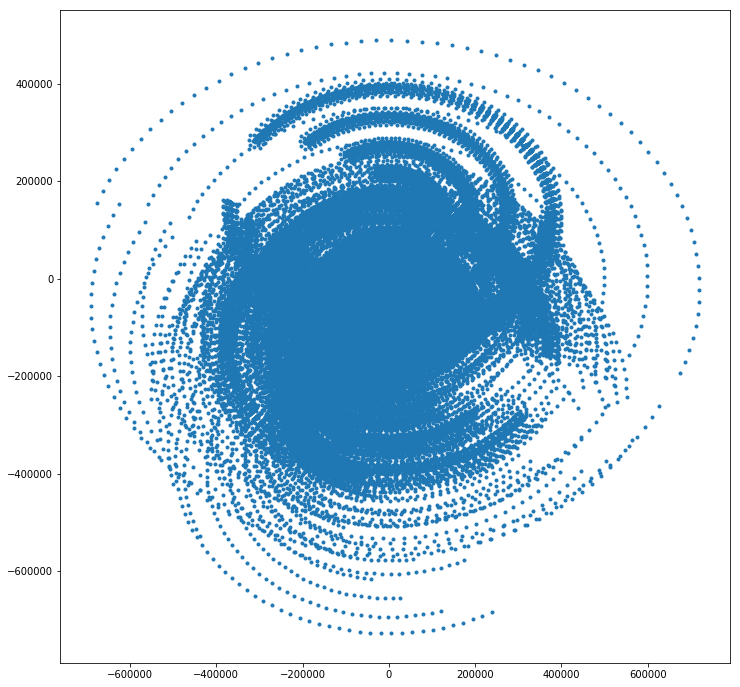

In [6]:
plt.clf()
plt.plot(vis.u, vis.v, '.')
plt.show()

In [7]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

vis = weight_list_serial_workflow([vis], [model])[0]

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 1400000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 400076.638635 wavelengths
create_image_from_visibility: Critical cellsize = 0.000001 radians, 0.000072 degrees
create_image_from_visibility: Cellsize          = 4.58215e-07 radians, 2.62538e-05 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]


In [8]:
from wrappers.serial.simulation.testing_support import create_test_skycomponents_from_s3

original_components = create_test_skycomponents_from_s3(flux_limit=1.0,
                                                      phasecentre=phasecentre,
                                                      polarisation_frame=PolarisationFrame("stokesI"),
                                                      frequency=numpy.array(frequency), 
                                                        radius=2*HWHM)


create_test_image_from_s3: Reading S3 sources from /Users/timcornwell/Code/algorithm-reference-library/data/models/S3_1400MHz_1mJy_18deg.csv 
create_test_skycomponents_from_s3: 56 sources read


### Calculate the voltage patterns with and without pointing errors

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 1400000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 400076.638635 wavelengths
create_image_from_visibility: Critical cellsize = 0.000001 radians, 0.000072 degrees
create_image_from_visibility: Cellsize          = 3.59235e-06 radians, 0.000205827 degrees
create_image_from_visibility: image shape is [1, 1, 4096, 4096]
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x121fdb710>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x121fdb710>
Setting pcolormesh
update_title_pos
findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts

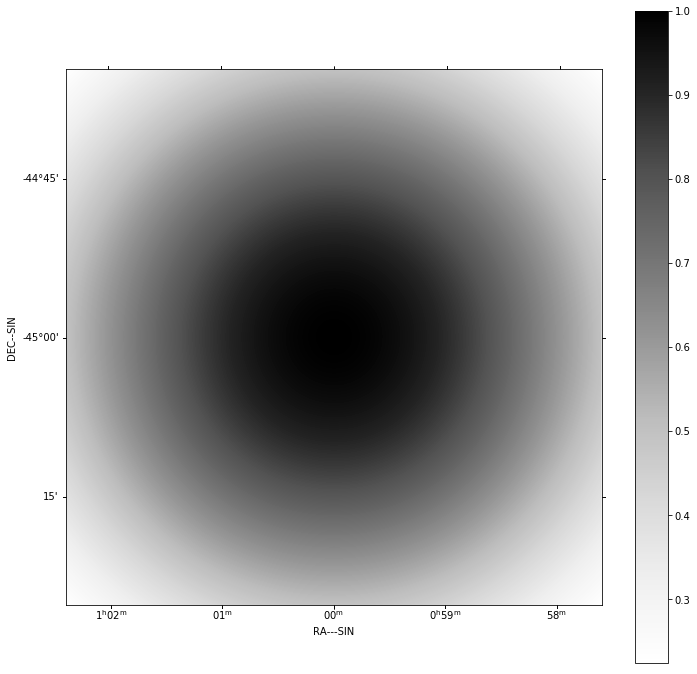

0.9999999999999976
0.498766764048061
[0.22389254 0.22408295 0.2242734  ... 0.22446389 0.2242734  0.22408295]


In [9]:
vp = create_image_from_visibility(block_vis, npixel=pb_npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=pb_cellsize, phasecentre=phasecentre,
                                 override_cellsize=False)

offset = [180.0*pb_cellsize*pb_npixel/(2.0*numpy.pi), 0.0]
offset = [0.0, 0.0]
HWHM=HWHM_deg * numpy.pi / 180.0
pb_direction = SkyCoord(ra=(+15.0 + offset[0]/numpy.cos(-45.0 * numpy.pi/180.0)) * u.deg, 
                        dec=(-45.0 + offset[1]) * u.deg, frame='icrs', equinox='J2000')
pb = create_pb(vp, 'MID', pointingcentre=pb_direction)
show_image(pb)
plt.show()
print(pb.data[0,0,pb_npixel//2,pb_npixel//2])
print(pb.data[0,0,0,pb_npixel//2])
print(pb.data[0,0,:,0])

In [10]:
vp = create_vp(vp, 'MID', pointingcentre=pb_direction)
pt = create_pointingtable_from_blockvisibility(block_vis, vp)

no_error_pt = simulate_pointingtable(pt, 0.0, 0.0, seed=18051955)
export_pointingtable_to_hdf5(no_error_pt, 'pointingsim_noerror_pointingtable.hdf5')
no_error_gt = create_gaintable_from_pointingtable(block_vis, original_components, no_error_pt, vp)

In [11]:
no_error_sm=[SkyModel(components=[original_components[i]], gaintable=no_error_gt[i]) 
             for i, _ in enumerate(original_components)]

In [12]:
no_error_vis = copy_visibility(vis)
no_error_vis = predict_skymodel_list_arlexecute_workflow(no_error_vis, no_error_sm, context='2d', docal=True)
no_error_vis=arlexecute.compute(no_error_vis, sync=True)[0]

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 302.33 MB detected in task graph: 
  (<data_models.memory_data_models.Visibility object ... 1aa3470>, None)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


simulate_pointingtable: Simulating dynamic pointing error = 4.84814e-06 (rad) 1 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '3.973670021599237e-06'
		min: '-3.605174867458815e-06'
		maxabs: '3.973670021599237e-06'
		rms: '7.316189323643025e-07'
		sum: '7.871883438951557e-06'
		medianabs: '4.896341835364363e-07'
		medianabsdevmedian: '4.895369063006614e-07'
		median: '1.907206455342723e-09'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x120f84160>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x120f84160>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


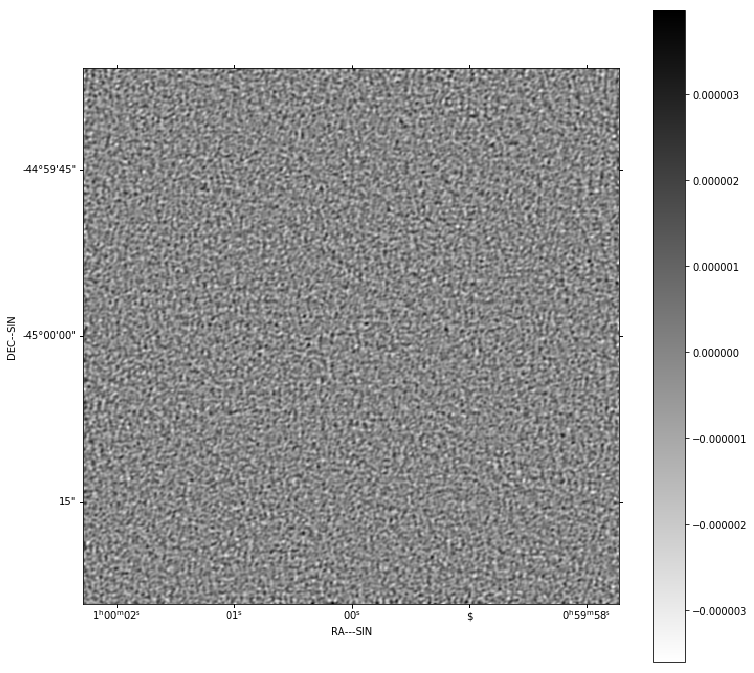

simulate_pointingtable: Simulating dynamic pointing error = 9.69627e-06 (rad) 2 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '7.950589634769906e-06'
		min: '-7.210042687688927e-06'
		maxabs: '7.950589634769906e-06'
		rms: '1.4629857703704353e-06'
		sum: '1.5820592580851814e-05'
		medianabs: '9.791998693421832e-07'
		medianabsdevmedian: '9.789862753985008e-07'
		median: '3.917349099602847e-09'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1256ea7b8>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1256ea7b8>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


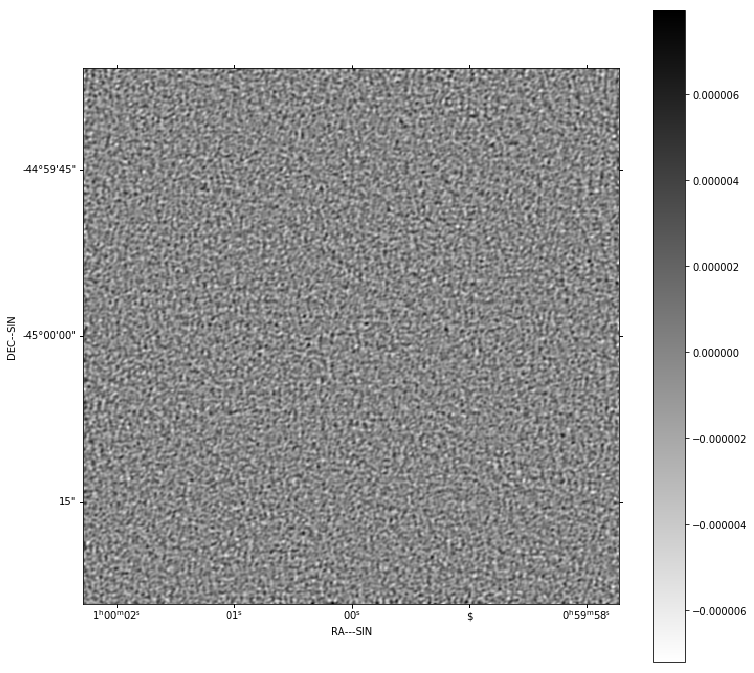

simulate_pointingtable: Simulating dynamic pointing error = 1.93925e-05 (rad) 4 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '1.591413180356608e-05'
		min: '-1.4418815661618188e-05'
		maxabs: '1.591413180356608e-05'
		rms: '2.9249943206385774e-06'
		sum: '3.1948633367041336e-05'
		medianabs: '1.9575278095233807e-06'
		medianabsdevmedian: '1.957835320875458e-06'
		median: '8.17390342825874e-09'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x123c2a9b0>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x123c2a9b0>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


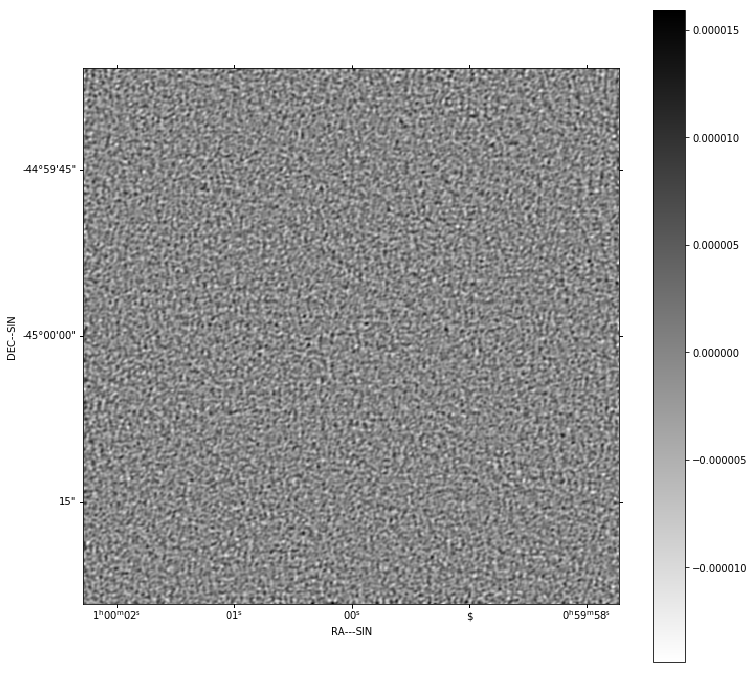

simulate_pointingtable: Simulating dynamic pointing error = 3.87851e-05 (rad) 8 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '3.187970590737228e-05'
		min: '-2.8832220517666625e-05'
		maxabs: '3.187970590737228e-05'
		rms: '5.846329497322047e-06'
		sum: '6.51282123283138e-05'
		medianabs: '3.91223367915202e-06'
		medianabsdevmedian: '3.91334330712703e-06'
		median: '1.82266052012525e-08'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x12290fcf8>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x12290fcf8>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


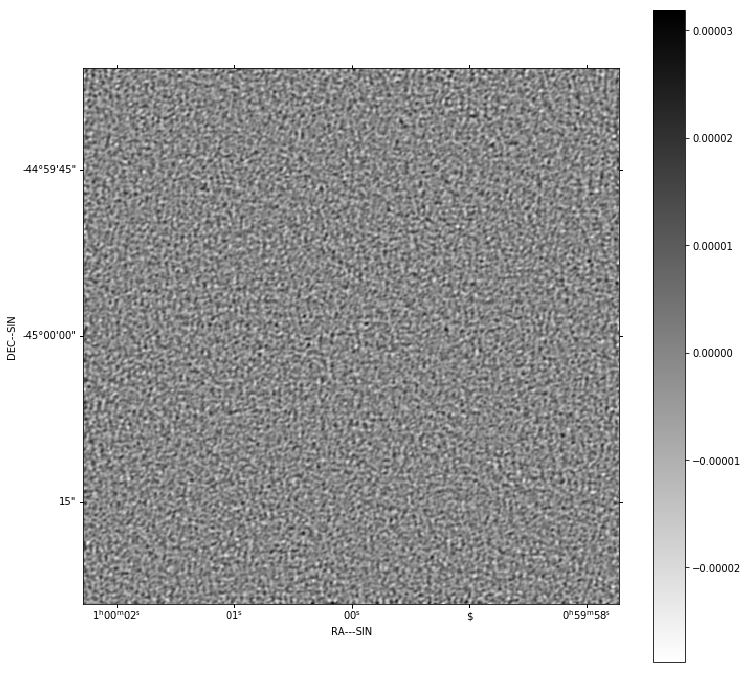

simulate_pointingtable: Simulating dynamic pointing error = 7.75702e-05 (rad) 16 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.396221959582103e-05'
		min: '-5.7640146327815604e-05'
		maxabs: '6.396221959582103e-05'
		rms: '1.1680027326723344e-05'
		sum: '0.00013518926134074947'
		medianabs: '7.818056544388833e-06'
		medianabsdevmedian: '7.819451684253853e-06'
		median: '4.149520336932421e-08'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x124fc6b00>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x124fc6b00>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


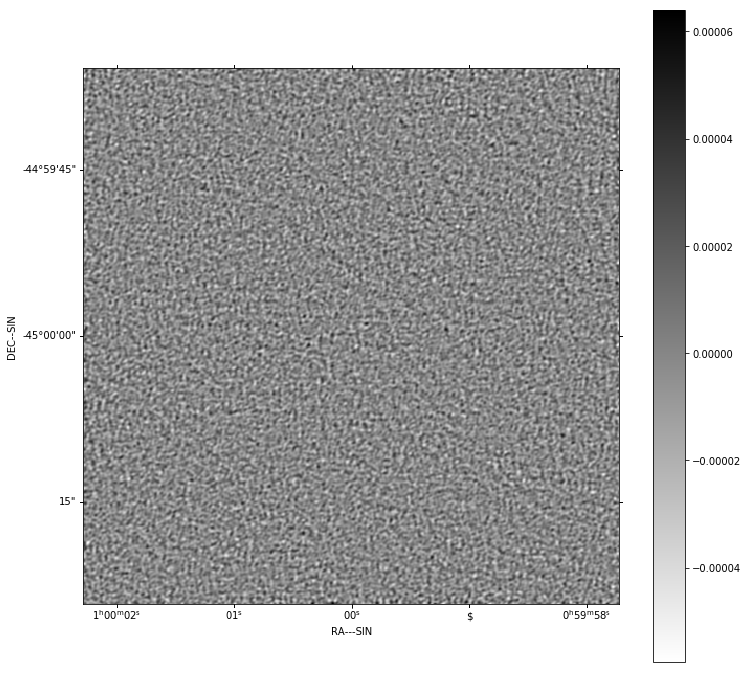

simulate_pointingtable: Simulating dynamic pointing error = 0.00015514 (rad) 32 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.0001287116847795585'
		min: '-0.00011516197208386869'
		maxabs: '0.0001287116847795585'
		rms: '2.332565905451806e-05'
		sum: '0.00029017954259467405'
		medianabs: '1.5628350201311052e-05'
		medianabsdevmedian: '1.5624699079948936e-05'
		median: '8.169485808253709e-08'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x125e13048>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x125e13048>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


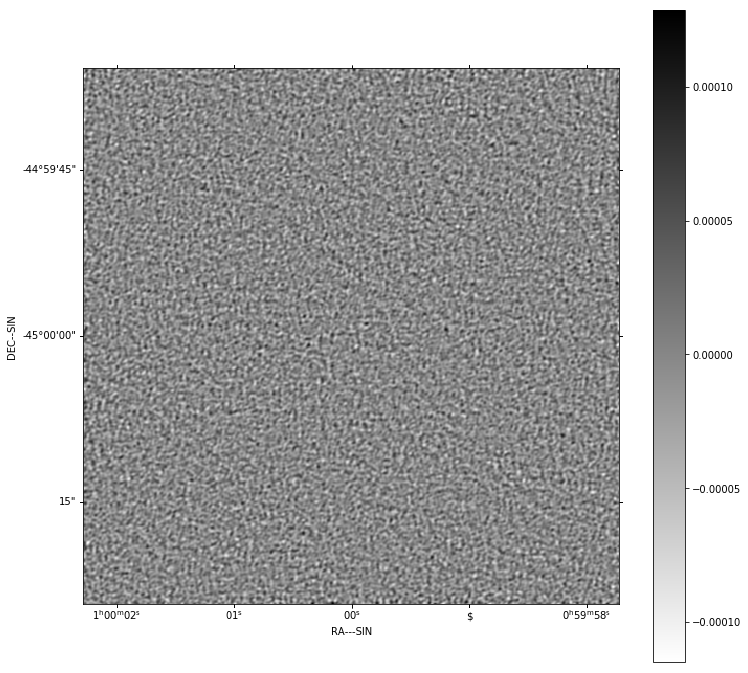

simulate_pointingtable: Simulating dynamic pointing error = 0.000310281 (rad) 64 (arcsec)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.0002603759444154029'
		min: '-0.00022968278332291336'
		maxabs: '0.0002603759444154029'
		rms: '4.6643585374111645e-05'
		sum: '0.0006600739559416684'
		medianabs: '3.125961035590795e-05'
		medianabsdevmedian: '3.1264259853526315e-05'
		median: '2.2706927050706686e-07'

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x126e80eb8>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x126e80eb8>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


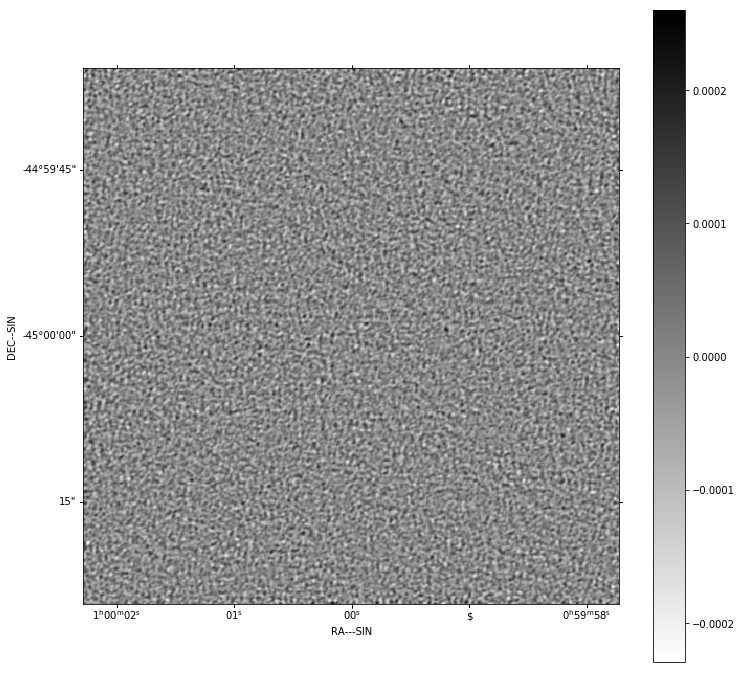

simulate_pointingtable: Simulating dynamic pointing error = 0.000620562 (rad) 128 (arcsec)


In [ ]:
static=0.0
dynamic=1.0
fwhm = 1.0
pes = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]
qas = []
for pe in pes:
    static_pointing_error = static * pe * numpy.pi/(3600.0*180.0)
    pointing_error = dynamic * pe * numpy.pi/(3600.0*180.0)
    error_pt = simulate_pointingtable(pt, pointing_error=pointing_error, 
                                      static_pointing_error=static_pointing_error, seed=18051955)
    export_pointingtable_to_hdf5(error_pt, 'pointingsim_error_arcsec%.1f_pointingtable.hdf5' % pe)


    error_gt = create_gaintable_from_pointingtable(block_vis, original_components, error_pt, vp)

    error_sm=[SkyModel(components=[original_components[i]], gaintable=error_gt[i]) 
             for i, _ in enumerate(original_components)]

    error_vis = copy_visibility(vis)
    error_vis = predict_skymodel_list_arlexecute_workflow(error_vis, error_sm, context='2d', docal=True)
    error_vis=arlexecute.compute(error_vis, sync=True)[0]

    error_vis.data['vis']-=no_error_vis.data['vis']
    
    dirty = invert_list_arlexecute_workflow([error_vis], [model], '2d')
    dirty, sumwt = arlexecute.compute(dirty, sync=True)[0]
    qa=qa_image(dirty)
    print(qa)
    qa.data['static_pointing_error'] = static_pointing_error
    qa.data['dynamic_pointing_error'] = pointing_error

    qas.append(qa)
    if True:
        show_image(dirty, cm='gray_r')
        plt.show()


In [ ]:
plt.clf()
for field in ['maxabs', 'rms', 'medianabs']:
    plt.loglog(pes, [q.data[field] for q in qas], '-', label=field)
plt.xlabel('Pointing error (arcsec)')
plt.ylabel('Error (Jy)')
plt.title('Error for S3SEX sky at %g Hz, %d times, full array: dynamic %g, static %g' % 
          (frequency[0], ntimes, dynamic, static))
plt.legend()
plt.show()

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
filename = seqfile.findNextFile(prefix='pointingsimulation', suffix='.tsv')
print('Saving results to %s' % filename)

epoch = time.strftime("%Y-%m-%d %H:%M:%S")

for qa in qas:
    qa.data['hostname'] = socket.gethostname()
    qa.data['epoch']= epoch
    qa.data['nb_name'] = nb_name
    
with open(filename, 'a') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=qas[0].data.keys(), delimiter='\t', quotechar='|',
                                quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for qa in qas:
        writer.writerow(qa.data)
    csvfile.close()